# 1. 파이썬으로 아달린 구현

## 아달린(ADAptive LInear Neuron)

### : 단일 신경망 중 하나로 연속함수로 cost함수 정의,  최소화 개념 사용

### (1) 아달린 규칙

     1. 선형활성화 함수 사용: 단순 항등함수, 실수 레이블
     2. 아달린 알고리즘은 진짜 class lable과 선형 활성화함수 실수출력값을 비교하여 모델 오차를 계산
        (퍼셉트론은 진짜 class lable과 예측 class lable 비교)

### (2) 경사하강법

    : cost 함수의 gradient가 반대방향으로 조금씩 가중치를 업데이트하는 방식
    *배치경사하강법 : 훈련세트의 모든 샘플을 기반으로 가중치 업데이트 계산하는 방식

### 1. 데이터셋 준비하기 

In [1]:
import os
import pandas as pd

s = os.path.join('https://archive.ics.uci.edu', 'ml', 'machine-learning-databases', 'iris', 'iris.data')

df = pd.read_csv(s, header=None, encoding='utf-8')

import matplotlib.pyplot as plt
import numpy as np

#setosa와 versicolor 선택
y = df.iloc[0:100, 4].values
y = np.where( y == 'Iris-setosa', -1, 1)

#꽃받침 길이와 꽃잎 길이 추출
X = df.iloc[0:100, [0,2]].values

### 2. 아달린 구현

In [2]:
#아달린 구현
class AdalineGD(object):
    
    #학습률 : 0.01, epoch: 50번
    def __init__(self, eta=0.01, n_iter=50, random_state=1): 
        self.eta=eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    #훈련 데이터 학습
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = [] #cost값을 리스트로 모음
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y-output)
            
            #가중치 업데이트
            self.w_[1:]+= self.eta*X.T.dot(errors)
            self.w_[0] += self.eta*errors.sum()
            #비용함수 구현
            cost=(errors**2).sum()/2.0
            self.cost_.append(cost)
        
        return self
    
    def net_input(self, X): #최종입력함수 
        return np.dot(X, self.w_[1:])+self.w_[0]
    
    def activation(self, X): #선형활성화함수 f(x)=x
        return X
    
    def predict(self, X): #단위계단함수로 임계함수 구현
        return np.where(self.activation(self.net_input(X))>=0.0,1,-1)
        

## (2) 최적으로 수렴하는 학습률(learning rate) 찾기

### eta가 0.1, eta가 0.0001 일 때의 에포크 대비 cost함수를 그래프화 하기



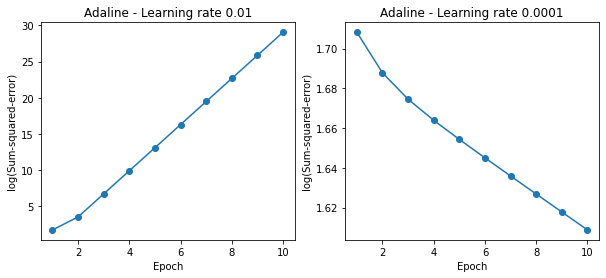

In [3]:
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(10,4))

#eta=0.1인 아달린 모델 그래프
ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X,y)
ax[0].plot(range(1, len(ada1.cost_)+1),np.log10(ada1.cost_), marker='o')

ax[0].set_xlabel('Epoch') #x축 :epoch
ax[0].set_ylabel('log(Sum-squared-error)') #y축: log(cost함수)
ax[0].set_title('Adaline - Learning rate 0.01')

#eta=0.0001인 아달린 모델 그래프
ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X,y)
ax[1].plot(range(1, len(ada2.cost_)+1),np.log10(ada2.cost_), marker='o')

ax[1].set_xlabel('Epoch') #x축 :epoch
ax[1].set_ylabel('log(Sum-squared-error)') #y축: log(cost함수)
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.show()

#### (1) eta가 0.1 일 때(학습률이 너무 클 때)

        :비용함수(y값)가 최소화되지 못하고 epoch마다 오차가 증가함.
        -> 전역 최솟값을 지남

#### (2) eta가 0.0001 일 때(학습률이 너무 작을 때)

        :비용이 감소하지만 전역 최솟값에 수렴하려면 epoch값이 많이 커야하는 단점이 존재함.

## (3) 특성스케일  조정으로 경사하강법 결과 향상

### 1) 표준화 특성 스케일 방법
####    : 데이터에 평균이 0, 단위 분산을 갖는 표준 정규분포 성질 부여 -> 경사하강법 학습의 수렴 촉진

#### [표준화 코드]

In [4]:
X_std = np.copy(X)
X_std[:, 0] = (X[:,0]-X[:,0].mean())/X[:,0].std()
X_std[:, 1] = (X[:,1]-X[:,1].mean())/X[:,1].std()

### 2) 표준화 후 아달린 모델 훈련, 학습률이 0.01일때 수렴 epoch 확인

In [6]:
#결정경계 시각화 함수 : plot_decision_regions 
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min()-1, X[:,0].max()+1
    x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),np.arange(x2_min, x2_max, resolution))
    
    Z =classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, c1 in enumerate(np.unique(y)):
        plt.scatter(x=X[y==c1, 0], y=X[y==c1,1], alpha=0.8, 
                    c=colors[idx], marker=markers[idx], label=c1, edgecolor='black')

/var/folders/6q/cy3y3kyx3218xz2ymsd6n8jc0000gn/T/ipykernel_981/1095293938.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==c1, 0], y=X[y==c1,1], alpha=0.8,


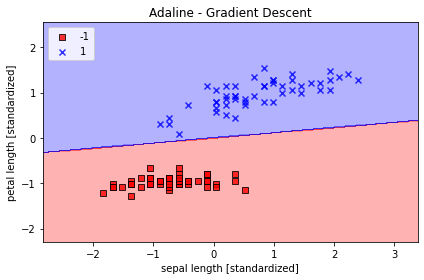

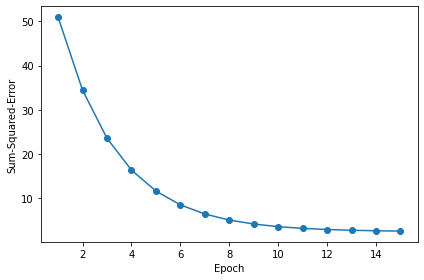

In [7]:
#표준화된 아달린으로 훈련
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

#결정경계 시각화 
plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#Epoch대비 SSE 시각화
plt.plot(range(1, len(ada.cost_)+1),ada.cost_, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Sum-Squared-Error')
plt.tight_layout()
plt.show()


#### [결과] : 모든 sample 완벽하게 분류되지만 SSE(sum-squared-error)는 0이 되지 않음

# 2. 대규모 머신러닝과 확률적 경사 하강법

### (1) 확률적 경사하강법(Stochastic gradient descent)

####  : 모든 샘플에 대하여 누적된 오차 합을 기반으로 가중치를 업데이트하는 대신
####     각 훈련 샘플에 대해 조금씩 가중치 업데이트 -> 수렴속도가 더 빠름

#### * 새로운 훈련 데이터가 도착하는 대로 훈련하는 온라인 학습(online learning)에도 사용가능

### (2) 아달린 모델에서 확률적 경사 하강법으로 가중치 업데이트

#### 1) fit 메서드에서 각 훈련 샘플에 대해 가중치 업데이트
#### 2) partial_fit( ) : 가중치를 다시 초기화하지 않는 메서드, 온라인 학습에서 사용가능
#### 3) 훈련 후 알고리즘 수렴 확인을 위해 epoch 마다 훈련 sample 평균 비용 계산
#### 4) 순환 방지를 위해 epoch가 일어나기 전에 훈련 샘플을 섞는 옵션 추가


#### [1] 매개변수 

      1. eta : 학습률(learning rate), 보통 0.0 ~ 1.0 사이 값으로 지정
      2. n_iter : 훈련 데이터 반복 횟수(epoch)
      3. random_state : 가중치 무작위 초기화를 위한 난수 생성 시드
      4. shuffle (default:True) : True로 설정하면 같은 반복이 되지 않도록 에포크마다 훈련데이터 섞음

#### [2]  속성

      1. W_ : 학습된 가중치 (1d-array로 구현)
      2. cost_ : 모든 훈련 샘플에 대해 에포크마다 누적된 평균비용함수의 제곱합

In [11]:
class AdalineSGD(object):
    
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
    
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            if self.shuffle:
                X,y = self._shuffle(X,y)
            
            cost = []
            for xi, target in zip(X,y):
                cost.append(self._update_weights(xi, target))
            
            avg_cost = sum(cost)/len(y)
            self.cost_.append(avg_cost)
        
        return self

    def partial_fit(self, X, y):
        """가중치를 다시 초기화하지 않고 훈련 데이터 학습"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0]>1:
            for xi, target in zip(X,y):
                self.update_weights(xi, target)
        else:
            self._update_weights(X,y)
        
        return self

    def _shuffle(self, X, y):
        
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1+m)
        self.w_initialized = True
    
    def _update_weights(self, xi, target):
        
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta*error
        cost = 0.5*error**2
        
        return cost
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:])+self.w_[0]
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        #단위계단함수로 클래스 레이블 반환
        return np.where(self.activation(self.net_input(X))>=0.0, 1, -1)
    
    

/var/folders/6q/cy3y3kyx3218xz2ymsd6n8jc0000gn/T/ipykernel_981/1095293938.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y==c1, 0], y=X[y==c1,1], alpha=0.8,


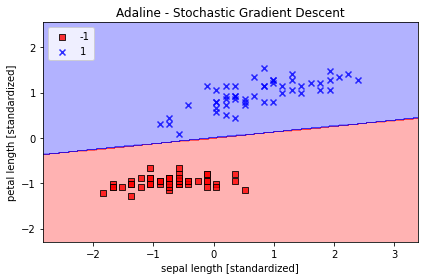

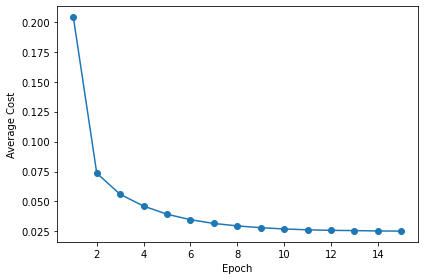

In [12]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

#결정경계 시각화 
plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#Epoch대비 SSE 시각화
plt.plot(range(1, len(ada.cost_)+1),ada.cost_, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Cost')
plt.tight_layout()
plt.show()
